In [31]:
# Dependencies
import pandas as pd
import numpy as np

In [32]:
# Load data (FRED-MD)
df = pd.read_csv(
    'current.csv',
    index_col='sasdate',
)

# Make the series stationary
def transform_series(series, code):
    if code == 1:
        return series  # No transformation
    elif code == 2:
        return series.diff().dropna()  # First difference
    elif code == 3:
        return series.diff().diff().dropna()  # Second difference
    elif code == 4:
        return np.log(series).dropna()  # Logarithm
    elif code == 5:
        return np.log(series).diff().dropna()  # First difference of logarithm
    elif code == 6:
        return np.log(series).diff().diff().dropna()  # Second difference of logarithm
    elif code == 7:
        return series.pct_change().dropna()  # Percentage change
    else:
        raise ValueError(f"Unknown transformation code: {code}")

transformed_data = {}
transformation_codes = df.iloc[0]  # Assuming the first row contains the codes
data = df.iloc[1:]  # The actual data starts from the second row

for column in data.columns:
    code = transformation_codes[column]
    transformed_data[column] = transform_series(data[column], code)

# Set index
data = pd.DataFrame(transformed_data).dropna()
data.index = pd.to_datetime(data.index)
data.head()

# Save last four as test
data_test = data[-4:]
data = data[:-4]

In [33]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

for idx, col in enumerate(data.columns):
    result = adfuller(data[col])
    if result[1] > 0.05:
        print(f'{idx}: {col} is not stationary')

In [34]:
# Fit the VAR model
from statsmodels.tsa.api import VAR

model = VAR(data)

# Select the optimal lag order
lag_order = model.select_order()
print(lag_order.summary())

# Fit the model
var_model = model.fit(lag_order.aic)
print(var_model.summary())

/home/js/.venvs/global/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/js/.venvs/global/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1113.     -1111.*      0.000*     -1112.*
1      -1115.      -950.4       0.000      -1050.
2     -1198.*      -869.7       0.000      -1068.
-------------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Mar, 2025
Time:                     13:16:04
--------------------------------------------------------------------
No. of Equations:         126.000    BIC:                   -869.711
Nobs:                     384.000    HQIC:                  -1067.59
Log likelihood:           193178.    FPE:                    0.00000
AIC:                     -1197.68    Det(Omega_mle):         0.00000
--------------------------------------------------------------------
Results for equation RPI
                        coefficient 

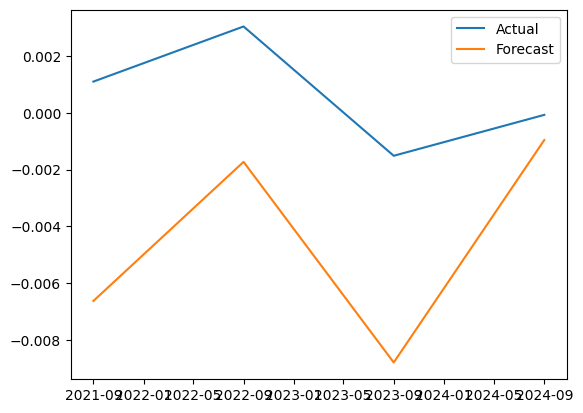

In [37]:
# Forecast the next 4 periods
forecast = var_model.forecast(data.values[-var_model.k_ar:], steps=4)
forecast_df = pd.DataFrame(forecast, columns=data.columns, index=data_test.index)

# Compare CPIAUCSL with test
import matplotlib.pyplot as plt
plt.plot(data_test['CPIAUCSL'], label='Actual')
plt.plot(forecast_df['CPIAUCSL'], label='Forecast')
plt.legend()
plt.show()